In [1]:
import geofield
import dipole
from matplotlib import pyplot, ticker
import numpy
import trig

%matplotlib nbagg

In [2]:
sha = geofield.SHADIFData("../data/sha.dif.14k/coef_EPSL_tnmgh.dat",
                          "../data/sha.dif.14k/error_coef_EPSL_tnmgh.dat")
gc_sai=numpy.loadtxt("../data/gh_AV.dat")

In [3]:
sai_gc = numpy.loadtxt("../data/sai.csv", delimiter=",")[:, 1:]
sai_years = numpy.loadtxt("../data/sai.csv", delimiter=",")[:, 0]

In [4]:
xd, yd, zd = dipole.ecc_dipole(sha.gcomp)
xds, yds, zds = dipole.ecc_dipole(sai_gc)
years = numpy.array(sha.years)

int_1 = ((years >= -800) & (years <= 1900))
int_2 = ((years >= -3000) & (years <= -800))

ints_1 = ((sai_years >= -800) & (sai_years <= 1900))
ints_2 = ((sai_years >= -3000) & (sai_years <= -800))

xd_avg_m800_1900 = numpy.average(xd[int_1])
yd_avg_m800_1900 = numpy.average(yd[int_1])
zd_avg_m800_1900 = numpy.average(zd[int_1])

xd_avg_m3000_m800 = numpy.average(xd[int_2])
yd_avg_m3000_m800 = numpy.average(yd[int_2])
zd_avg_m3000_m800 = numpy.average(zd[int_2])

xds_avg_m800_1900 = numpy.average(xds[ints_1])
yds_avg_m800_1900 = numpy.average(yds[ints_1])
zds_avg_m800_1900 = numpy.average(zds[ints_1])

xds_avg_m3000_m800 = numpy.average(xds[ints_2])
yds_avg_m3000_m800 = numpy.average(yds[ints_2])
zds_avg_m3000_m800 = numpy.average(zds[ints_2])

phid = numpy.arctan2(yd,xd)
rd = numpy.sqrt(xd**2 + yd**2)

phids = numpy.arctan2(yds,xds)
rds = numpy.sqrt(xds**2 + yds**2)

<IPython.core.display.Javascript object>


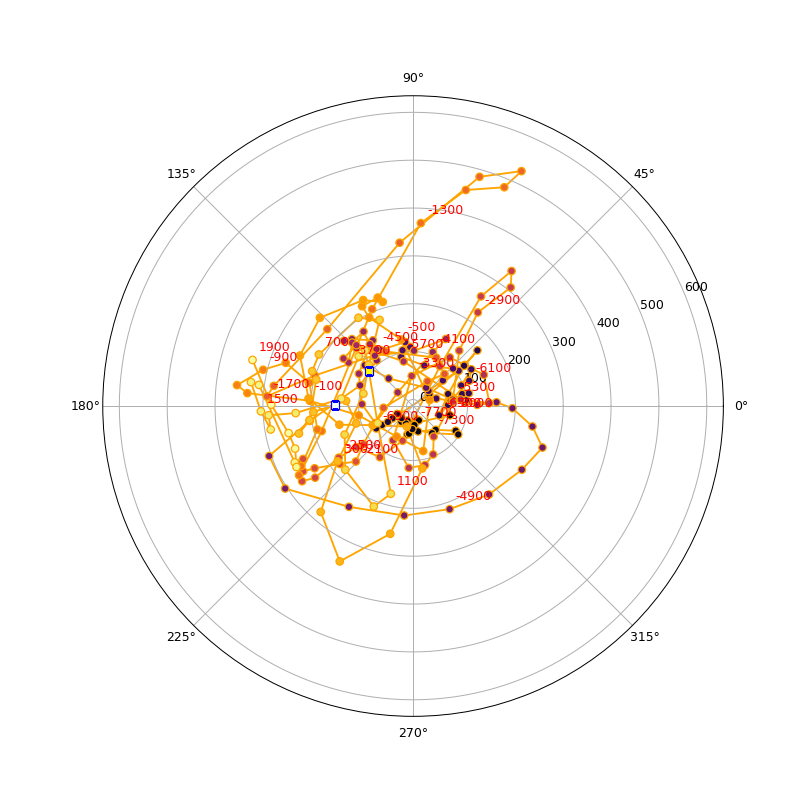

In [5]:
fig, ax = pyplot.subplots(figsize=(9,9), subplot_kw={"polar" : True})

ax.plot(phid[(years <= -1000) & (years >= -8000)],
        rd[(years <= -1000) & (years >= -8000)], color = "orange", zorder=1)
ax.plot(phid[years >= -1000], rd[years >= -1000], color = "orange", zorder=1)
ax.scatter(phid[years >= -8000], rd[years >= -8000]
           , c=numpy.linspace(0, 1, len(phid[years >= -8000])), cmap="inferno", edgecolors="orange", zorder=2)

for i in range(len(phid[years >= -8000])-1, 0, -8):
    ax.annotate(str(int(years[years >= -8000][i])), (phid[years >= -8000][i], rd[years >= -8000][i]),
                zorder=3, color="red",
                xytext=(5,7), textcoords="offset points")
ax.annotate(str(int(years[years >= -8000][0])), (phid[years >= -8000][0], rd[years >= -8000][0]), zorder=3, color="red",
            xytext=(5,7), textcoords="offset points")

ax.scatter(numpy.arctan2(yd_avg_m3000_m800, xd_avg_m3000_m800),
           numpy.sqrt(xd_avg_m3000_m800**2 + yd_avg_m3000_m800**2), color = "yellow", s=40,
           edgecolors="blue", zorder=7, marker="s")
ax.scatter(numpy.arctan2(yd_avg_m800_1900, xd_avg_m800_1900),
           numpy.sqrt(xd_avg_m800_1900**2 + yd_avg_m800_1900**2), color = "mintcream", s=40,
           edgecolors="blue", zorder=7, marker="s")


In [17]:
# velocity
vel_xs = numpy.gradient(xds, 25.)
vel_ys = numpy.gradient(yds, 25.)
vel_zs = numpy.gradient(zds, 25.)
vel_mags = numpy.sqrt(vel_xs**2 + vel_ys**2 + vel_zs**2)

# acceleration

acc_xs = numpy.gradient(vel_xs, 25.)
acc_ys = numpy.gradient(vel_ys, 25.)
acc_zs = numpy.gradient(vel_zs, 25.)
acc_mags = numpy.sqrt(acc_xs**2 + acc_ys**2 + acc_zs**2)
d_mag_v = numpy.gradient(vel_mags, 25.)

import scipy.signal

n_windows = 6
acc_filtered = numpy.convolve(acc_mags, numpy.ones((n_windows,))/n_windows, mode='same')
d_mag_v_filtered = numpy.convolve(d_mag_v, numpy.ones((n_windows,))/n_windows, mode='same')


In [7]:
# power
dip_power = dipole.power(sai_gc, 1, 1)
quad_power = dipole.power(sai_gc, 2, 2)
big_power = dipole.power(sai_gc, 1, 10)

<IPython.core.display.Javascript object>


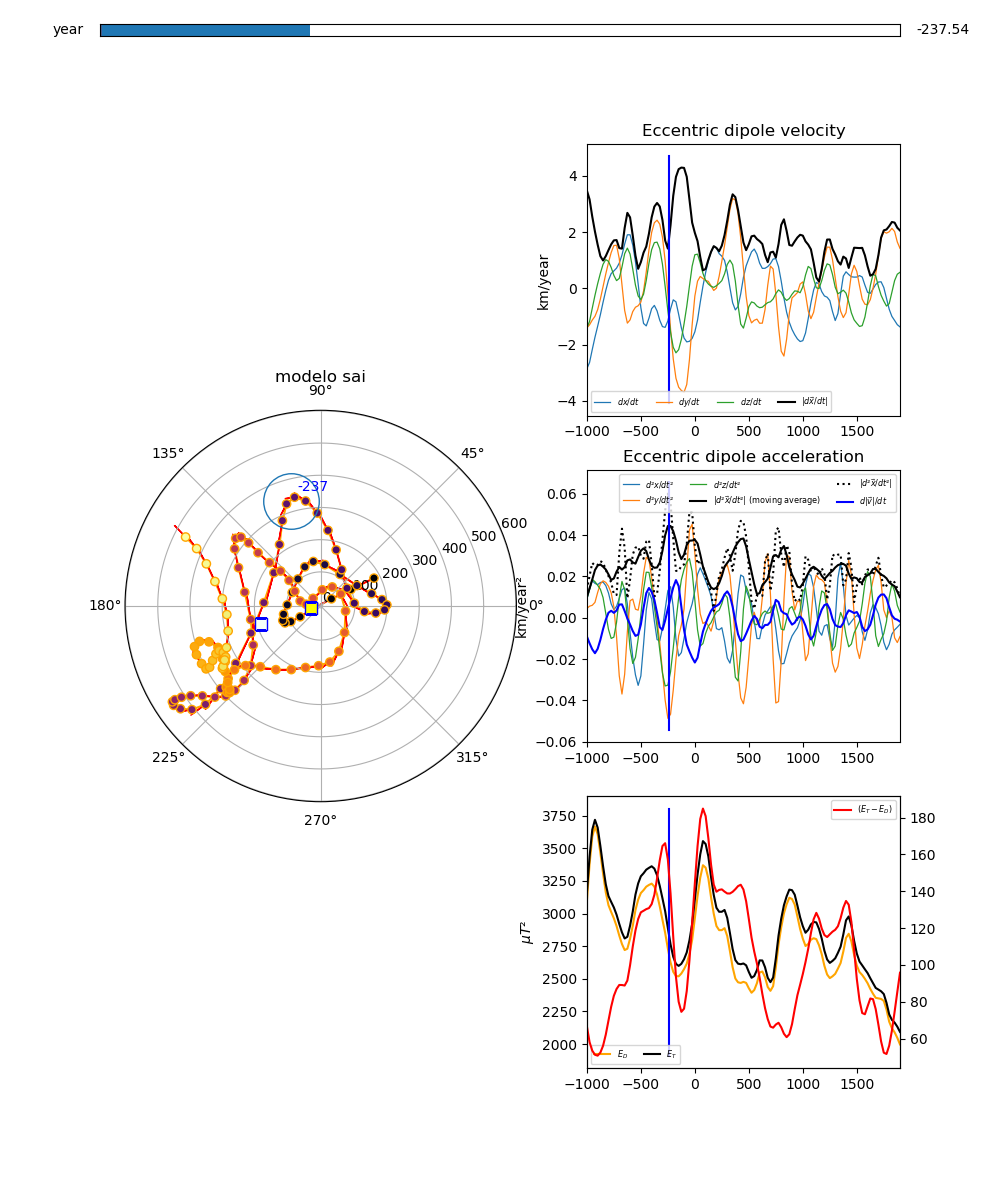

In [22]:
import matplotlib
fig = pyplot.figure(figsize=(10,12))
gs = matplotlib.gridspec.GridSpec(3, 2, width_ratios=[1.25, 1])

ax = fig.add_subplot(gs[:, 0], projection="polar", )
ax0 = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[2, 1])
ax_slider = fig.add_axes((0.1, 0.97, 0.8, 0.01))

import matplotlib.widgets
slider = matplotlib.widgets.Slider(ax_slider, "year", valmin=-1000, valmax=1900, valinit=-1000)
xds_interp = scipy.interpolate.interp1d(sai_years, xds)
yds_interp = scipy.interpolate.interp1d(sai_years, yds)

x_cursor = xds_interp(-1000)
y_cursor = yds_interp(-1000)

r_cursor = numpy.sqrt(x_cursor**2+y_cursor**2)
phi_cursor = numpy.arctan2(y_cursor, x_cursor)

text = ax.annotate(str(int(-1000)), (phi_cursor, r_cursor), zorder=3, color="blue",
                    xytext=(5,7), textcoords="offset points")

dot = ax.plot(phi_cursor, r_cursor, marker="o", markersize=40, markerfacecolor='none')[0]

def sliders_on_changed(val):
    x_cursor = xds_interp(val)
    y_cursor = yds_interp(val)
    r_cursor = numpy.sqrt(x_cursor**2+y_cursor**2)
    phi_cursor = numpy.arctan2(y_cursor, x_cursor)
    dot.set_data(phi_cursor, r_cursor)
    text.xy = (phi_cursor, r_cursor)
    text.set_text(str(int(val)))
    for vline in vlines:
        vline[0].set_xdata((val, val))

    
slider.on_changed(sliders_on_changed)

arrowsize = 25

ax.plot(phids, rds, color = "orange", zorder=1)
ax.scatter(phids, rds, c=numpy.linspace(0, 1, len(phids)), cmap="inferno", edgecolors="orange", zorder=2)
#for i in range(len(phids)-1, 0, -8):
#    ax.annotate(str(int(sai_years[i])), (phids[i], rds[i]), zorder=3, color="red",
#                xytext=(5,7), textcoords="offset points")
#ax.annotate(str(int(sai_years[0])), (phids[0], rds[0]), zorder=3, color="red",
#            xytext=(5,7), textcoords="offset points")

ax.scatter(numpy.arctan2(yds_avg_m3000_m800, xds_avg_m3000_m800),
           numpy.sqrt(xds_avg_m3000_m800**2 + yds_avg_m3000_m800**2), color = "yellow", s=80,
           edgecolors="blue", zorder=7, marker="s")
ax.scatter(numpy.arctan2(yds_avg_m800_1900, xds_avg_m800_1900),
           numpy.sqrt(xds_avg_m800_1900**2 + yds_avg_m800_1900**2), color = "mintcream", s=80,
           edgecolors="blue", zorder=7, marker="s")

for x, y, vx, vy in zip(xds, yds, vel_xs, vel_ys):
    phi = numpy.arctan2(y, x)
    r = numpy.sqrt(x**2 + y**2)
    ax.arrow(
        phi,
        r,
        numpy.arctan2(y + vy*arrowsize, x + vx*arrowsize) - phi,
        numpy.sqrt((x+vx*arrowsize)**2 + (y+vy*arrowsize)**2) - r,
        color="red",
    )

ax.set_title("modelo sai")

thin_style = {"linewidth" : 0.9}

ax0.plot(sai_years, vel_xs, **thin_style, label="$dx/dt$")
ax0.plot(sai_years, vel_ys, **thin_style, label="$dy/dt$")
ax0.plot(sai_years, vel_zs, **thin_style, label="$dz/dt$")

ax0.plot(sai_years, vel_mags, color="black", label="$|d\\vec{x}/dt|$")

ax1.plot(sai_years, acc_xs, **thin_style, label="$d²x/dt²$")
ax1.plot(sai_years, acc_ys, **thin_style, label="$d²y/dt²$")
ax1.plot(sai_years, acc_zs, **thin_style, label="$d²z/dt²$")

ax1.plot(sai_years, acc_filtered, color="black", label="$|d²\\vec{x}/dt²|$ (moving average)")
ax1.plot(sai_years, acc_mags, color="black", linestyle=":", label="$|d²\\vec{x}/dt²|$")
ax1.plot(sai_years, d_mag_v_filtered, color="blue", linestyle="-", label="$d|\\vec{v}|/dt$")

ax2b = ax2.twinx()
ax2.plot(sai_years, dip_power, color="orange", label="$E_D$")
ax2.plot(sai_years, big_power, color="black", label="$E_T$")
ax2b.plot(sai_years, (big_power - dip_power), color="red", label="$(E_T - E_D)$")

vlines = [ax.plot([-1000, -1000], ax.get_ybound(), color="blue") for ax in (ax0, ax1, ax2)]

ax0.set_xbound(-1000, 1900)
ax0.set_ylabel("km/year")
ax0.set_title("Eccentric dipole velocity")
ax0.legend(ncol=4, fontsize="xx-small")
ax1.set_xbound(-1000, 1900)
ax1.set_ylabel("km/year²")
ax1.set_title("Eccentric dipole acceleration")
ax1.legend(ncol=3, fontsize="xx-small")
ax2.set_xbound(-1000, 1900)
ax2.set_ylabel("$\mu T²$")
ax2.legend(ncol=3, loc="lower left", fontsize="xx-small")
ax2b.legend(ncol=3, loc="upper right", fontsize="xx-small")

fig.show()

In [9]:
import subprocess

cals_years = numpy.arange(-10000, 1900, 50)
gc_cals = numpy.zeros((len(cals_years), 10*(10+2)))
for i, year in enumerate(cals_years):
    subprocess.call(f'(cd ../cals10k.1b && echo "{int(year)}" | ./a.out)', shell=True)
    bigarray = numpy.loadtxt('../cals10k.1b/coefs.dat')
    gc = []
    for row in bigarray:
        gc.append(row[2])
        if row[1] != 0:
            gc.append(row[3])
    gc_cals[i, :] = numpy.array(gc)
    

In [10]:
xdc, ydc, zdc = dipole.ecc_dipole(gc_cals)

intc_1 = ((cals_years >= -800) & (cals_years <= 1900))
intc_2 = ((cals_years >= -3000) & (cals_years <= -800))

xdc_avg_m800_1900 = numpy.average(xdc[intc_1])
ydc_avg_m800_1900 = numpy.average(ydc[intc_1])
zdc_avg_m800_1900 = numpy.average(zdc[intc_1])

xdc_avg_m3000_m800 = numpy.average(xdc[intc_2])
ydc_avg_m3000_m800 = numpy.average(ydc[intc_2])
zdc_avg_m3000_m800 = numpy.average(zdc[intc_2])

phidc = numpy.arctan2(ydc,xdc)
rdc = numpy.sqrt(xdc**2 + ydc**2)

<IPython.core.display.Javascript object>


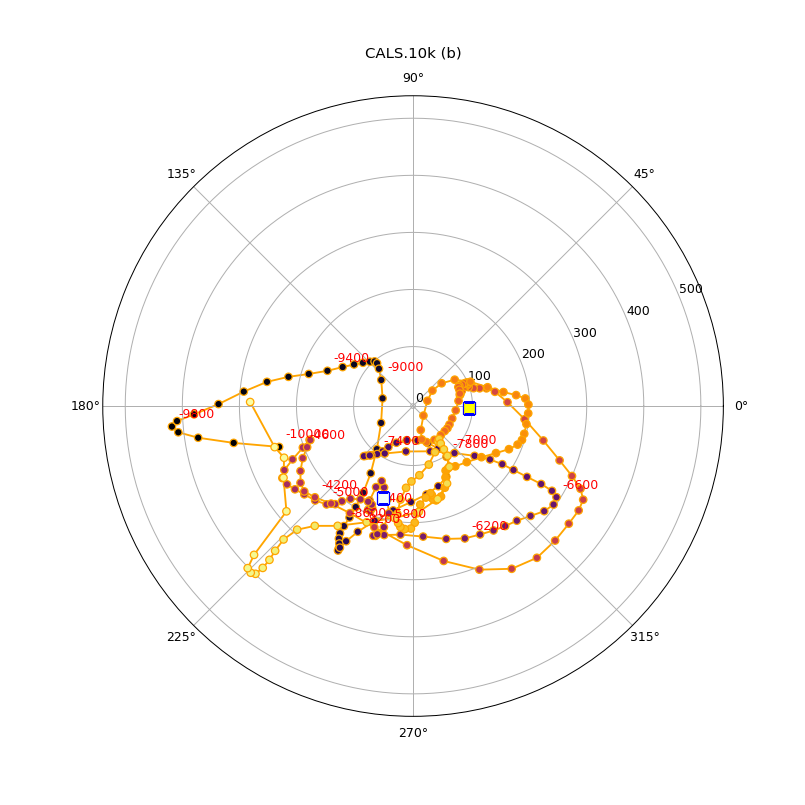

Text(0.5,1.05,'CALS.10k (b)')

In [11]:
fig, ax = pyplot.subplots(figsize=(9,9), subplot_kw={"polar" : True})
ax.plot(phidc, rdc, color = "orange", zorder=1)
ax.scatter(phidc, rdc, c=numpy.linspace(0, 1, len(phidc)), cmap="inferno", edgecolors="orange", zorder=2)
for i in range(len(phids)-1, 0, -8):
    ax.annotate(str(int(cals_years[i])), (phidc[i], rdc[i]), zorder=3, color="red",
                xytext=(5,7), textcoords="offset points")
ax.annotate(str(int(cals_years[0])), (phidc[0], rdc[0]), zorder=3, color="red",
            xytext=(5,7), textcoords="offset points")

ax.scatter(numpy.arctan2(ydc_avg_m3000_m800, xdc_avg_m3000_m800),
           numpy.sqrt(xdc_avg_m3000_m800**2 + ydc_avg_m3000_m800**2), color = "yellow", s=80,
           edgecolors="blue", zorder=7, marker="s")
ax.scatter(numpy.arctan2(ydc_avg_m800_1900, xdc_avg_m800_1900),
           numpy.sqrt(xdc_avg_m800_1900**2 + ydc_avg_m800_1900**2), color = "mintcream", s=80,
           edgecolors="blue", zorder=7, marker="s")

ax.set_title("CALS.10k (b)")